# Neural Network Hyperparameters

This tutorial provides code that helps experimenting with different neural network hyperparameters, including different learning rate schedules.

In [35]:
# Import keras and other functionality
import tensorflow as tf
from tensorflow import keras
from tensorflow import random
from keras.callbacks import EarlyStopping, ModelCheckpoint

keras.backend.clear_session()
random.set_seed(42)

In [38]:
# Load Fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

# Select 55,000 datapoints for training and 5,000 datapoints for validation
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [39]:
# Preprocess training and validation data
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [40]:
# Use early stopping to avoid wasting resources with unnecessary training
# Training will stop if validation loss does not improve for 5 epochs (patience)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Callback to save best model (according to validation loss)
name_model = 'keras_best_model.keras'
best_model = ModelCheckpoint(name_model, monitor='val_loss', mode='min', save_best_only=True)

call_backs=[early_stopping, best_model] 

# Choose optimiser (SGD, ADAM, etc.) and learning rate
l_rate=0.01
opt = keras.optimizers.SGD(learning_rate=l_rate)

In [41]:
# Define neural network in keras using specified hyperparameters
def build_and_train_model(n_hidden=2, n_neurons=[300,100], optimizer=keras.optimizers.SGD(learning_rate=0.01), i_shape=[28, 28], epochs=30, call_backs=[]):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=i_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons[layer], activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
   
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=call_backs)

    return model, history

In [30]:
# Build and train model using specific hyperparameters
[model, history] = build_and_train_model(n_hidden=2, n_neurons=[300,100], optimizer=opt, i_shape=[28, 28], epochs=50, call_backs=[early_stopping, best_model])

Epoch 1/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7093 - accuracy: 0.7656 - val_loss: 0.5029 - val_accuracy: 0.8234
Epoch 2/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4849 - accuracy: 0.8313 - val_loss: 0.4581 - val_accuracy: 0.8344
Epoch 3/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4393 - accuracy: 0.8453 - val_loss: 0.4216 - val_accuracy: 0.8540
Epoch 4/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4153 - accuracy: 0.8543 - val_loss: 0.3953 - val_accuracy: 0.8642
Epoch 5/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3948 - accuracy: 0.8618 - val_loss: 0.3931 - val_accuracy: 0.8644
Epoch 6/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3790 - accuracy: 0.8663 - val_loss: 0.3908 - val_accuracy: 0.8622
Epoch 7/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3667 - accuracy: 0.8700 - val_loss: 0.3711 - val_accuracy:

In [31]:
# Check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


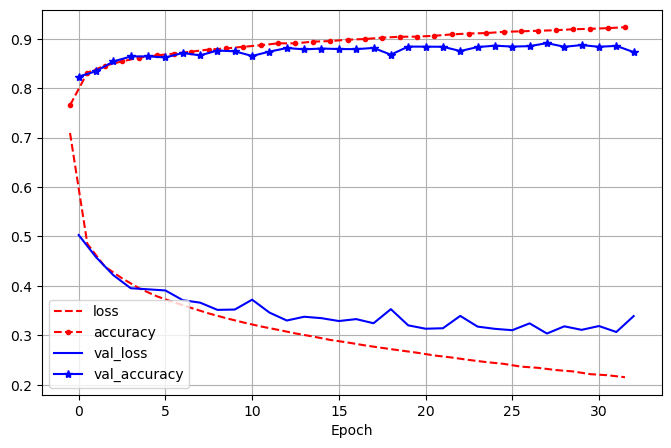

In [32]:
# Create function for plotting learning curves
import numpy as np
import matplotlib.pyplot as plt

def plot_curves(history):
    plt.figure(figsize=(8, 5))
    for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
        epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
        plt.plot(epochs, history.history[key], style, label=key)
    plt.xlabel("Epoch")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

plot_curves(history)

In [33]:
# Load best model from training
saved_model = keras.models.load_model(name_model)

# Evaluate on the validation data (don't use test data if you are comparing different hyperparameters)
saved_model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.3036 - accuracy: 0.8912


[0.30361559987068176, 0.8912000060081482]

## Learning Rate Schedule

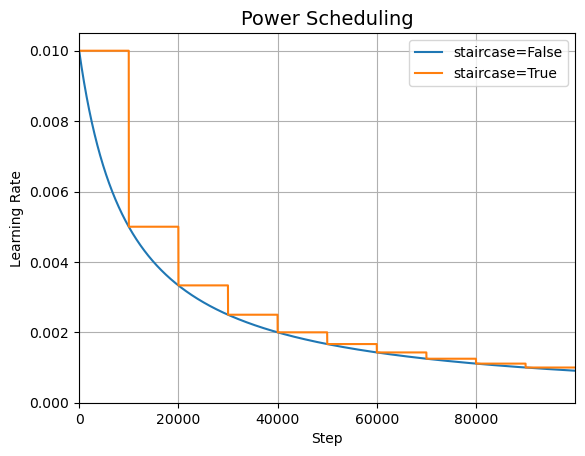

In [34]:
# Create function for plotting learning curves
import numpy as np
import matplotlib.pyplot as plt 

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [36]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [42]:
# Build and train model using specific hyperparameters
[model, history] = build_and_train_model(n_hidden=2, n_neurons=[300,100], optimizer=opt, i_shape=[28, 28], epochs=50, call_backs=[early_stopping, best_model])

Epoch 1/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7121 - accuracy: 0.7683 - val_loss: 0.4969 - val_accuracy: 0.8306
Epoch 2/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4814 - accuracy: 0.8329 - val_loss: 0.4597 - val_accuracy: 0.8316
Epoch 3/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4358 - accuracy: 0.8469 - val_loss: 0.4201 - val_accuracy: 0.8516
Epoch 4/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4115 - accuracy: 0.8556 - val_loss: 0.3915 - val_accuracy: 0.8646
Epoch 5/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3909 - accuracy: 0.8621 - val_loss: 0.3865 - val_accuracy: 0.8602
Epoch 6/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3745 - accuracy: 0.8687 - val_loss: 0.3851 - val_accuracy: 0.8660
Epoch 7/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3622 - accuracy: 0.8706 - val_loss: 0.3665 - val_accuracy:

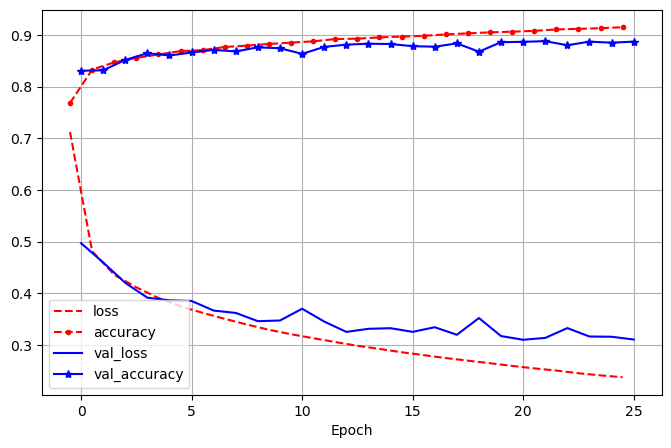

In [43]:
plot_curves(history)

In [44]:
# Load best model from training
saved_model = keras.models.load_model(name_model)

# Evaluate on the validation data (don't use test data if you are comparing different hyperparameters)
saved_model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.3100 - accuracy: 0.8866


[0.3100210130214691, 0.8866000175476074]

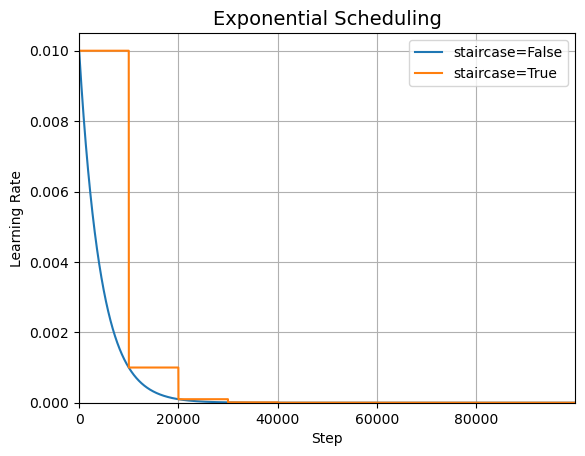

In [48]:
initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [49]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=0.1,
    staircase=False
)
opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

Epoch 1/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7235 - accuracy: 0.7604 - val_loss: 0.5249 - val_accuracy: 0.8238
Epoch 2/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5008 - accuracy: 0.8284 - val_loss: 0.4706 - val_accuracy: 0.8324
Epoch 3/50
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4622 - accuracy: 0.8403 - val_loss: 0.4446 - val_accuracy: 0.8386
Epoch 4/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4443 - accuracy: 0.8473 - val_loss: 0.4349 - val_accuracy: 0.8444
Epoch 5/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4331 - accuracy: 0.8518 - val_loss: 0.4280 - val_accuracy: 0.8448
Epoch 6/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4264 - accuracy: 0.8528 - val_loss: 0.4266 - val_accuracy: 0.8464
Epoch 7/50
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4222 - accuracy: 0.8546 - val_loss: 0.4212 - val_accuracy:

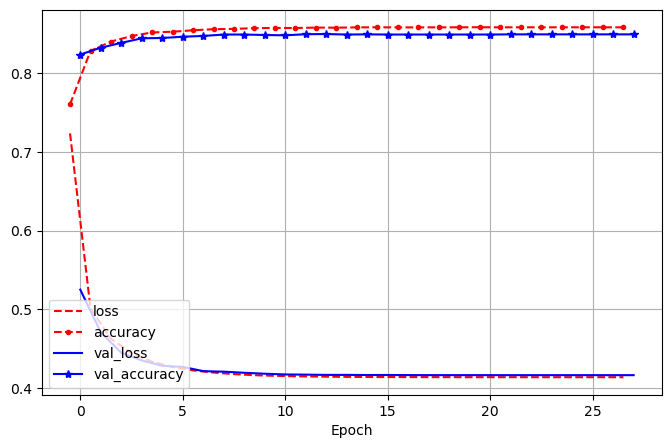

In [50]:
# Build and train model using specific hyperparameters
[model, history] = build_and_train_model(n_hidden=2, n_neurons=[300,100], optimizer=opt, i_shape=[28, 28], epochs=50, call_backs=[early_stopping, best_model])

plot_curves(history)